In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/biomass/Biomass_History.csv
/kaggle/input/distance/Distance_Matrix.csv


In [3]:
!pip install keras-rl2


In [4]:
import plotly.express as px
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredLogarithmicError,MeanSquaredError,MeanAbsoluteError
from matplotlib import pyplot as plt
from shapely.geometry import Point, MultiPoint
import rtree
from sklearn.neighbors import NearestNeighbors
from gym import Env
from gym.spaces import Box, MultiDiscrete, Dict,Discrete
from shapely.ops import nearest_points
import geopandas as gpd
import seaborn as sns
import random
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
%matplotlib inline

In [5]:
biomass = pd.read_csv("/kaggle/input/biomass/Biomass_History.csv")
distance = pd.read_csv("/kaggle/input/distance/Distance_Matrix.csv")
# creating point objects, will be useful later on 
points = []
for i, row in biomass.iterrows():
    points.append((float(row['Longitude']),float(row["Latitude"])) )

biomass["Geometries"] = points
biomass["Type"] = "Biomass prod.plants"
print(biomass.head())


   Index  Latitude  Longitude       2010       2011       2012       2013  \
0      0  24.66818   71.33144   8.475744   8.868568   9.202181   6.023070   
1      1  24.66818   71.41106  24.029778  28.551348  25.866415  21.634459   
2      2  24.66818   71.49069  44.831635  66.111168  56.982258  53.003735   
3      3  24.66818   71.57031  59.974419  80.821304  78.956543  63.160561   
4      4  24.66818   71.64994  14.653370  19.327524  21.928144  17.899586   

        2014       2015       2016        2017            Geometries  \
0  10.788374   6.647325   7.387925    5.180296  (71.33144, 24.66818)   
1  34.419411  27.361908  40.431847   42.126945  (71.41106, 24.66818)   
2  70.917908  42.517117  59.181629   73.203232  (71.49069, 24.66818)   
3  93.513924  70.203171  74.536720  101.067352  (71.57031, 24.66818)   
4  19.534035  19.165791  16.531315   26.086885  (71.64994, 24.66818)   

                  Type  
0  Biomass prod.plants  
1  Biomass prod.plants  
2  Biomass prod.plants  
3  B

In [9]:
distance.iloc[1,19]


28.637400000000003

/tmp/ipykernel_32/1850315607.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(biomass.corr(), annot=True)


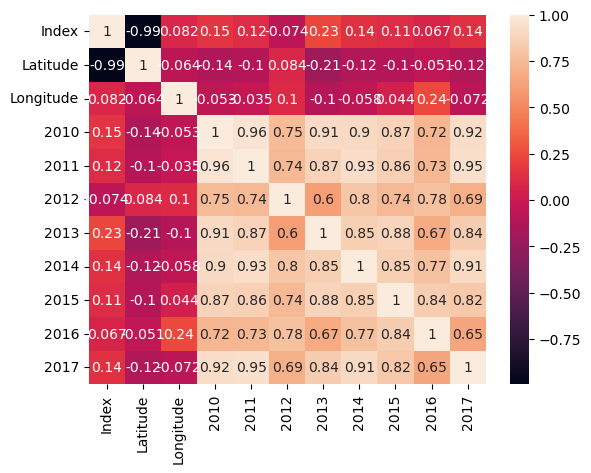

In [25]:
sns.heatmap(biomass.corr(), annot=True)
plt.show()

In [9]:
fig = px.scatter_mapbox(biomass, lat="Latitude", lon="Longitude",hover_data=["Index"],
                        color="2014", zoom=3, height=400)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show(renderer='iframe')

In [7]:
#predictions using neural networks

""" First a little data prep. We need to batch the results from 2010 till 2016, the 2017 
results will serve as the target values for the neural network"""

x = biomass[[str(i+2000) for i in range(10,17)]].values
print(x.shape)
y = biomass["2017"].values
print(y.shape)
scaler = StandardScaler()
x = scaler.fit_transform(x)
X_train,X_test,Y_train,Y_test = train_test_split(x,y, test_size = 0.25, random_state = 32)
print (X_train.shape, X_test.shape)


def build_net_no_dropout(input_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(input_size,activation = 'relu'))
    model.add(tf.keras.layers.Dense(128, activation = "relu"))
    model.add(tf.keras.layers.Dense(32, activation = "relu"))
    model.add(tf.keras.layers.Dense(1, activation = 'relu'))
    return model


def build_net_with_dropout(input_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(input_size,activation = 'relu',kernel_regularizer = tf.keras.regularizers.L1(0.01)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(128, activation = "relu",kernel_regularizer = tf.keras.regularizers.L1(0.01)))
    model.add(tf.keras.layers.Dropout(0.7))
    model.add(tf.keras.layers.Dense(32, activation = "relu",kernel_regularizer = tf.keras.regularizers.L1(0.01)))
    model.add(tf.keras.layers.Dense(1, activation = 'relu'))
    return model

def model_run(model,train_x,val_y, train_y, val_x, num_epochs):
    loss = MeanSquaredLogarithmicError()
    optimizer = Adam(learning_rate = 0.005)
    model.compile( loss= loss, optimizer = optimizer, metrics = ["msle"])
    #training
    history = model.fit(train_x,train_y, epochs = num_epochs,batch_size= 70, verbose = 1,validation_data = (val_x,val_y))
    return history

def plotter(history,metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric,'val_'+metric])
    plt.show()
    



(2418, 7)
(2418,)
(1813, 7) (605, 7)


Epoch 1/30
26/26 [==============================] - 1s 12ms/step - loss: 9.4147 - msle: 9.4147 - val_loss: 3.3718 - val_msle: 3.3718
Epoch 2/30
26/26 [==============================] - 0s 3ms/step - loss: 2.4486 - msle: 2.4486 - val_loss: 1.6855 - val_msle: 1.6855
Epoch 3/30
26/26 [==============================] - 0s 3ms/step - loss: 1.4323 - msle: 1.4323 - val_loss: 1.0327 - val_msle: 1.0327
Epoch 4/30
26/26 [==============================] - 0s 3ms/step - loss: 0.8647 - msle: 0.8647 - val_loss: 0.6019 - val_msle: 0.6019
Epoch 5/30
26/26 [==============================] - 0s 4ms/step - loss: 0.4727 - msle: 0.4727 - val_loss: 0.3330 - val_msle: 0.3330
Epoch 6/30
26/26 [==============================] - 0s 4ms/step - loss: 0.3139 - msle: 0.3139 - val_loss: 0.2378 - val_msle: 0.2378
Epoch 7/30
26/26 [==============================] - 0s 3ms/step - loss: 0.2268 - msle: 0.2268 - val_loss: 0.2096 - val_msle: 0.2096
Epoch 8/30
26/26 [==============================] - 0s 4ms/step - loss: 0.2

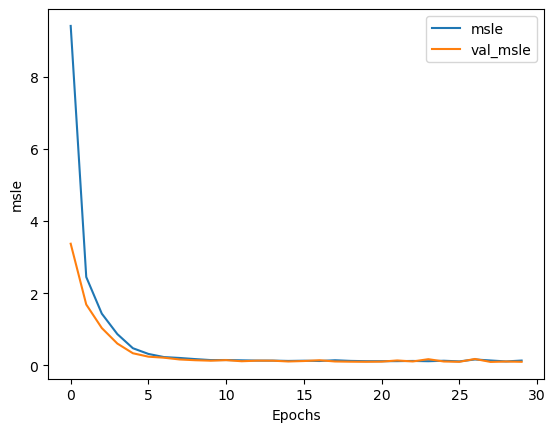

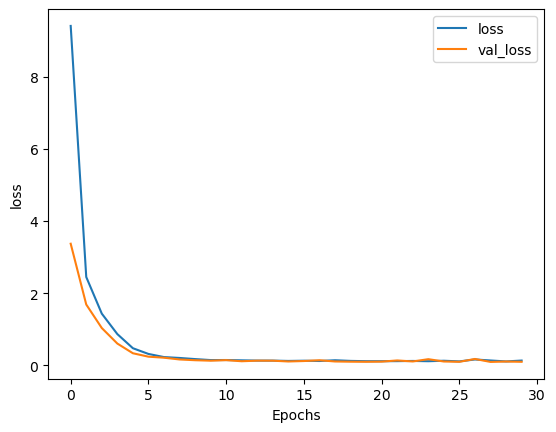

In [8]:
#putting it all together

ann_without = build_net_no_dropout(X_train.shape[1])
hist_ann_without = model_run(ann_without,X_train,Y_test,Y_train,X_test,30)
plotter(hist_ann_without, "msle")
plotter(hist_ann_without, "loss")


In [ ]:
ann_with = build_net_with_dropout(X_train.shape[1])
hist_ann_with = model_run(ann_with,X_train,Y_test,Y_train,X_test,40)
plotter(hist_ann_with, "msle")
plotter(hist_ann_with, "loss")

19/19 [==============================] - 0s 1ms/step


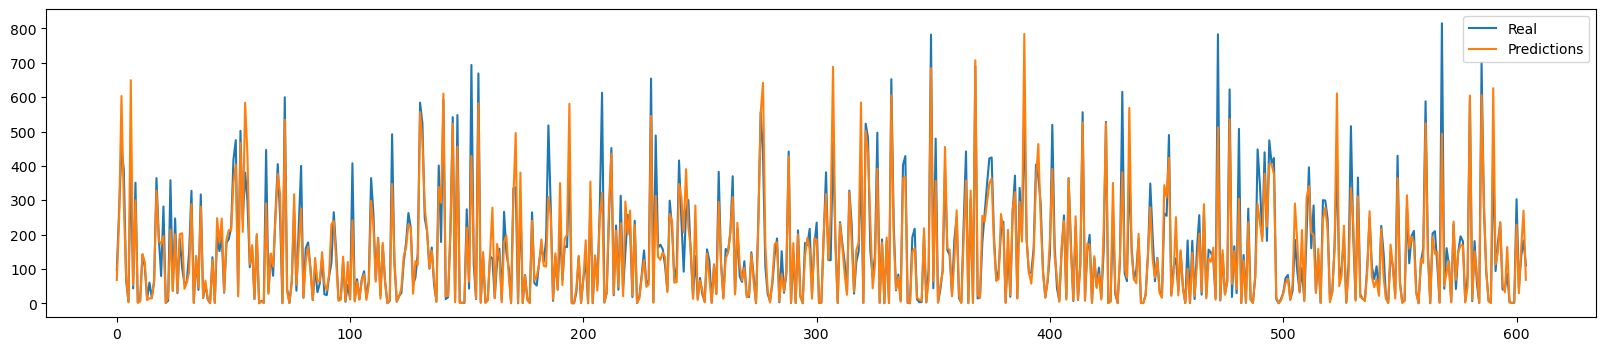

In [12]:

Predictions = ann_without.predict(X_test)
Real = Y_test
dft = pd.DataFrame({"real_2017":list(Y_test),"Prediction_2017":list(Predictions)})
plt.figure(figsize =(20,4))
plt.plot(dft["real_2017"])
plt.plot(dft["Prediction_2017"])
plt.legend(["Real", "Predictions"])
plt.show()

In [23]:
# each additional component in the waste to energy supply chain will be represented 

class Component():
    def __init__(self, index, name, num, cap, points,k, pointx,data=biomass.copy(),distance = distance.copy(),refinery=False,spare =points.copy()):
        self.name = name
        self.index = index
        self.num = num        
        self.capacity = cap
        self.tree = rtree.index.Rtree()
        if refinery==True:
            self.point = spare[index]
            
        else:
            self.point = points[index]
            del(spare)
        for i,p in enumerate(pointx):
            self.tree.insert(i,p+p,p)
       
            
        
        # k nearest point
        self.sources= list(self.tree.nearest(self.point, k,objects='raw' ))
        #print(len(self.sources))
        self.sources_index = []
        
        for i in self.sources:
            if refinery ==False:
                self.sources_index.append(points.index(i))
                pointx.remove(i)
            elif refinery == True:
                self.sources_index.append(points.index(i))
                pointx.remove(i)
                
        self.sources= self.sources[1:]
        self.sources_index= self.sources_index[1:]
        #print("Original number of sources {}".format(len(self.sources)))
        
        #this part calculates the total output of the sources  
        sources_output = data["2017"][self.sources_index].sum()
        
        self.under_util = 0
        if sources_output>self.capacity:
            while True:
                pointx.append(self.sources[-1])
                self.sources.pop()
                self.sources_index.pop()
                sources_output = data["2017"][self.sources_index].sum()
                
                if sources_output<=self.capacity:
                    self.under_util = self.capacity-sources_output
                    break
                else:
                    continue
           
        self.total_dist = 0
        for i in self.sources_index:
            self.total_dist+=distance.iloc[i,self.index]
        self.pointx = pointx[:]
        #print("final number of sources {}".format(len(self.sources)))
        
    def prevent_duplicates(self):
        return self.pointx
            
    def add(self,df):
        q= int(self.index)
        df.Type[q] = str(self.name)
        return df
    def cost(self):
        return self.total_dist,self.under_util
        



def make_components(number,name, k, cap,pointlist,pointx=[],index_=-1,refinery=False):
    
    components = [] 
    if index_<-1 and len(pointx)!=0:        
    else:
        listr = [] 
        pointx = pointlist[:]
        for i in range(number):
            index = random.randint(0,2417)
            if index not in listr :
                
                
                comp = Component(index,name,i,cap,pointlist,k,pointx,refinery = refinery)
                pointx= comp.prevent_duplicates()
                components.append(comp)
                listr.append(index)
                
            else:
                i = i-1
                continue
    print("done")
    return components,pointx
        
    
    
     
    
    


In [46]:
refs=Component(90,"depo_location",90,2000,points,3,points[2:2220],refinery = False)
print(refs.index)

90


In [70]:
#creating a custom environment with gym

class Environment(Env):
    def __init__(self,num_dep,num_refinery, points = points):
        a = 0.001
        b = 1
        c = 1
        self.k = 80
        self.points = points 
        self.num_dep = num_dep
        self.refinery_cap = 100000
        self.num_refinery = num_refinery
        self.dep_cap = 20000
        self.depots,self.pointx = make_components(num_dep,"depot_location",self.k, 20000,points)
        self.dep_points = [q.point for q in self.depots]
        self.refineries,self.refpointx = make_components(self.num_refinery,"refinery_location",int(num_dep//num_refinery), 100000,self.dep_points,refinery=True)
        self.ref_points = [q.point for q in self.refineries]
        self.transport = 0
        self.underutil = 0
        self.ndim=(self.num_dep+self.num_refinery,2)
        self.observation_space = Box(high= np.inf,low = -np.inf,shape = (1,))
        self.action_space =Discrete(np.prod(self.ndim))
        for i in self.depots:
            tr,un = i.cost()
            self.transport+=tr
            self.underutil+=un
        for i in self.refineries:
            tr,un = i.cost()
            self.transport+=tr
            self.underutil+=un
        self.state = (a*self.transport)+(c*self.underutil)
        self.episode_len = 80
        self.previous_score = []
            
    def observe(self):
        return np.array([self.state])
    
    def reset(self):
        self.__init__(self.num_dep,self.num_refinery, self.points)
        print(self.observation_space.shape)
        obs = self.observe()
        return obs
        
    def recalc (self):
        a = 0.001
        b = 1
        c = 1
        for i in self.depots:
            tr,un = i.cost()
            self.transport+=tr
            self.underutil+=un
        for i in self.refineries:
            tr,un = i.cost()
            self.transport+=tr
            self.underutil+=un
        var = (a*self.transport)+(c*self.underutil)
        return var
        
    def close(self):
        pass
        
    def step(self, action):
        reward = 0
        mapping = tuple(np.ndindex(self.ndim))
        action = mapping[action]
        if action[0]>(self.num_dep-1) and self.episode_len>0:
            # if the agent picks from [0, self.num_dep] that indicates a depot, else its a refinery
            # in this case it is a refinery that has been selected
            self.episode_len -= 1 
              #selcting one the final motion [left:0,right:1]                
            rp = self.ref_points[action[0]-self.num_dep]
            indx = self.points.index(rp)
            if action[1] == 0: #left
                if indx-10>=0:
                    for i in self.refineries[action[0]-self.num_dep].sources:
                        self.refpointx.append(i)
                        
                        
                    ref_new =Component(indx-10,"refinery_location",indx-10,100000,self.dep_points,4,self.refpointx,refinery = True)
                    self.refpointx = ref_new.prevent_duplicates()
                    self.refineries[action[0]-self.num_dep] = ref_new
                    self.ref_points[action[0]-self.num_dep] = ref_new.point 
                    self.state = self.recalc() 
                else:
                    reward -= 20
                    
            elif action[1] == 1:# right
                if indx+10<=2417:
                    for i in self.refineries[action[0]-self.num_dep].sources:
                        self.refpointx.append(i)
                    ref_new,self.refpointx=Component(indx+10,"refinery_location",indx+10,100000,self.dep_points,4,self.refpointx,refinery = True)                     
                    print(type(ref_new))
                    self.refineries[action[0]-self.num_dep] =ref_new
                   
                    self.ref_points[action[0]-self.num_dep] =ref_new.point 
                    self.state = self.recalc()
                else:
                    reward -= 20      
            
        else:                               #in this case the agent selects a depot
            self.episode_len -= 1 
              #selcting one the final motion [left,right]
            dp = self.dep_points[action[0]]
            indx = self.points.index(dp)
            if action[1] == 0: #left
                
                if indx-10>=0:
                    for i in self.depots[action[0]].sources:
                        self.pointx.append(i)
                    dep_new= Component(indx-10,"depot_location",indx-10,20000,self.points,self.k,self.pointx,refinery = False)
                    self.pointx=dep_new.prevent_duplicates() 
                    
                    self.depots[action[0]] =dep_new
                    self.dep_points[action[0]] =dep_new.point 
                    self.state = self.recalc() 
                else:
                    reward -= 20
                    
            elif action[1] == 1:# right
                if indx+10<=2417:
                    for i in self.depots[action[0]].sources:
                        self.pointx.append(i)
                    dep_new = Component(indx+10,"depot_location",indx+10,20000,self.points,self.k,self.pointx,refinery = False)                    
                    self.pointx=dep_new.prevent_duplicates() 
                    self.depots[action[0]] =dep_new
                    self.dep_points[action[0]] =dep_new.point 
                    self.state = self.recalc() 
                else:
                    reward -= 20
                    
                    
                
        
        # Calculating the reward
        if len(self.previous_score)>0:
            reward += (20*(self.previous_score[-1]-self.state))/self.previous_score[-1]
            self.previous_score.append(self.state)
 
  
        elif len(self.previous_score)==0:
            self.previous_score.append(self.state) 
            
             
        
        # Checking if episode is done
        if self.episode_len <= 0: 
            done = True
        else:
            done = False
        
        # Setting the placeholder for info
        info = {}
        
        # Returning the step information
        return self.observe(), reward, done,info

In [71]:
Enviro = Environment(23,5)
state = Enviro.observation_space.shape
actions = Enviro.action_space.n

done
done


In [25]:
!pip install rl-agents==0.1.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.2 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.17.3-py3-none-any.whl size=1654651 sha256=16a52dbdac1df460574a991452e2b4f29d06583a331c5384728b8772f2aad388
  Stored in directory: /root/.cache/pip/wheels/af/4b/74/fcfc8238472c34d7f96508a63c962ff3ac9485a9a4137afd4e
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.1
    Uninstalling cloudpickle-2.2.1:
      Successfully uninstalled cloudpickle-2.2.1
  Attempting uninstall: gym
    Found existing installation: gym 0.26.2
    Uninstalling gym-0.26.2:
      Successfully uninstalled gym-0.26.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.6.1 requires

In [51]:
# model
model = tf.keras.models.Sequential()    
model.add(tf.keras.layers.Dense(12, activation='relu', input_shape =(1,1)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(actions, activation='linear'))


In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1, 1, 24)          72        
                                                                 
 flatten (Flatten)           (None, 24)                0         
                                                                 
 dense_6 (Dense)             (None, 128)               3200      
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 56)                7224      
                                                                 
Total params: 27,008
Trainable params: 27,008
Non-trainable params: 0
_________________________________________________________________


In [52]:

def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [73]:
Agent = build_agent(model, actions)
Agent.compile(tf.keras.optimizers.legacy.Adam(learning_rate=1e-3), metrics=['mae'])
Agent.fit(Enviro , nb_steps=60, visualize=False, verbose=1)

Training for 60 steps ...
done
done
(1,)
Interval 1 (0 steps performed)


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   11/10000 [..............................] - ETA: 10:16 - reward: -3.6789

/opt/conda/lib/python3.10/site-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   13/10000 [..............................] - ETA: 23:03 - reward: -3.3611

/opt/conda/lib/python3.10/site-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


ValueError: (73.56094, 22.41137) is not in list